## Урок № 5. Случайный лес.

### Задание № 3*.
Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [47]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=10, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

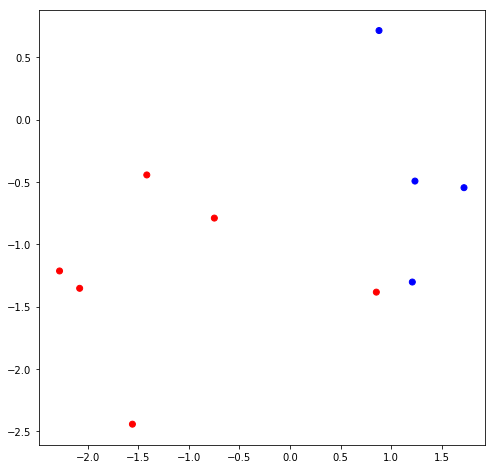

In [48]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [93]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = [] # новая бутстреп выборка
    b_index_lst = [] # список для учёта индексов попавших в bootstrap-выборку
        
    for i in range(N): # цикл по кол-ву деревьев
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_index_lst = np.zeros(data.shape[0])
        b_data_oob = np.zeros(data.shape)
        b_labels_oob = np.zeros(labels.shape)
        
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1) # выбираем индекс нового объекта бутстреп выборки
            b_data[j] = data[sample_index] 
            b_labels[j] = labels[sample_index]
            b_index_lst[sample_index] = 1 # помечаем индекс значения признака попавшего в bootstrap-выборку

                
        b_data_oob = data[b_index_lst == 0].copy() # сохраняем значения признаков не попавших в bootstrap-выборку
        b_labels_oob = labels[b_index_lst == 0].copy() # сохраняем хначения ответов не попавших в bootstrap-выборку 
        #print(b_index_lst)
        bootstrap.append((b_data, b_labels, b_data_oob, b_labels_oob))
        
    return bootstrap

In [51]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes) # перемешаем индексы
    subsample = sample_indexes[0:len_subsample].copy() # возьмем первые len_subsample
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    #print(f'subsample = {subsample}')
    return subsample

In [52]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [53]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [54]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
# !!! ИЗМЕНЕНИЯ !!! 
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample: # выбираем из подпространства признаков, для каждого нового разбиения будет новое подпространство 
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [73]:
def random_forest(data, labels, n_trees):
    forest = [] # список деревьев
    train_d = []
    train_l = []    
    test_d = []
    test_l = []
    bootstrap = get_bootstrap(data, labels, n_trees) # создаем n_trees бутстреп выборок
    
    for b_data, b_labels, b_data_oob, b_labels_oob in bootstrap:
        forest.append(build_tree(b_data, b_labels)) # добавляем по дереву в ансамбль
        
        train_d.append(b_data)
        train_l.append(b_labels)        
        
        test_d.append(b_data_oob)
        test_l.append(b_labels_oob)
        
    train_data = [train_d, train_l]
    test_data = [test_d, test_l]
        
    return forest, train_data, test_data

In [74]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)  
    
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
#     for tree in forest:
    for i in range(len(forest)):
        predictions.append(predict(data[i], forest[i]))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    #print(f'predictions_per_object = {predictions_per_object}')  
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    #print(f'voted_predictions = {voted_predictions}')    
    return voted_predictions

In [75]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [94]:
n_trees = 3
my_forest_1, train_data_lst, test_data_lst = random_forest(classification_data, classification_labels, n_trees)

In [95]:
train_data_lst # Данные, на которых обучались деревья

[[array([[-1.41472405, -0.4432379 ],
         [-2.07819849, -1.35300531],
         [-0.74721104, -0.78946417],
         [-1.55678081, -2.44321773],
         [-1.55678081, -2.44321773],
         [ 0.88004085,  0.71551528],
         [-1.41472405, -0.4432379 ],
         [ 0.85360236, -1.38360609],
         [-1.41472405, -0.4432379 ],
         [ 1.23514024, -0.4923893 ]]), array([[-2.27689555, -1.21369452],
         [-2.07819849, -1.35300531],
         [-2.07819849, -1.35300531],
         [-1.41472405, -0.4432379 ],
         [-1.55678081, -2.44321773],
         [-1.55678081, -2.44321773],
         [ 0.85360236, -1.38360609],
         [ 1.23514024, -0.4923893 ],
         [-2.07819849, -1.35300531],
         [ 0.85360236, -1.38360609]]), array([[-1.55678081, -2.44321773],
         [ 0.85360236, -1.38360609],
         [-2.27689555, -1.21369452],
         [-1.55678081, -2.44321773],
         [ 1.71980627, -0.5453551 ],
         [ 1.23514024, -0.4923893 ],
         [-0.74721104, -0.78946417],
 

In [96]:
test_data_lst # Данные, которые не попали в bootatrap-выборку по каждому из деревьев

[[array([[ 1.20909706, -1.30260885],
         [-2.27689555, -1.21369452],
         [ 1.71980627, -0.5453551 ]]), array([[ 0.88004085,  0.71551528],
         [-0.74721104, -0.78946417],
         [ 1.20909706, -1.30260885],
         [ 1.71980627, -0.5453551 ]]), array([[-1.41472405, -0.4432379 ],
         [ 1.20909706, -1.30260885]])],
 [array([1, 0, 1]), array([1, 0, 1, 1]), array([0, 1])]]

### К сожалению, потратив непростительно много времени на поиск решения, так и не придумал как продвинуться далее, т.к. имея на руках трейн и тест выборки под каждое дерево не понятно как их использовать далее...Согласно теории, для каждого объекта на котором не обучалось подмножество деревьев леса делается прогноз как на тесте, но как это лаконично закодить и расчитать accuracy на множестве датасетов по количеству равному количеству деревьев не понял...это нужно проверять качество каждого дерева

In [97]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data_lst[0])
train_answers

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [85]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data_lst[0])
test_answers

[1.0, 0.0, 1.0, 1.0]

In [80]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_data_lst[1], train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [140]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_dataset[1], test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 96.667


Text(0.5, 1.0, 'Test accuracy=96.67')

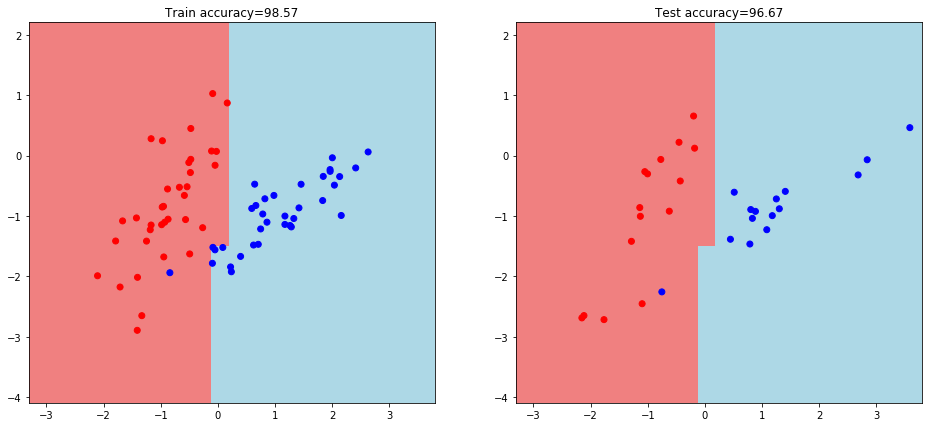

In [141]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) # определяем цвета квадратов в сетке

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')